## Part 4: Feature Engineer
1. Lag features - Capture temporal dependencies
2. Moving average features - Smooth short-term fluctuations
3. Rolling statistics - Statistical features over windows
4. Interaction features - Multivariate relationships
5. Fourier transform features - Cyclical patterns
6. Time aggregation comparison - Different aggregation strategies


## Setup: Import Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully!")


✓ Libraries imported successfully!


## 4.1 Load Preprocessed Data


In [6]:
print("=== Load preprocessed data ===")

# Load scaled training and test data
train_data = pd.read_csv('../data/processed/train_data_scaled.csv', 
                         index_col='DateTime', parse_dates=True)
test_data = pd.read_csv('../data/processed/test_data_scaled.csv', 
                        index_col='DateTime', parse_dates=True)

print(f"Train data shape: {train_data.shape}")
print(f"Train date range: {train_data.index.min()} to {train_data.index.max()}")
print(f"Test data shape: {test_data.shape}")
print(f"Test date range: {test_data.index.min()} to {test_data.index.max()}")

# Define variable groups
pollutant_list = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
sensor_list = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
meteo_vars = ['T', 'RH', 'AH']
continuous_features = pollutant_list + sensor_list + meteo_vars

print(f"\nFeatures to engineer: {len(continuous_features)} continuous features")
print(f"Current columns: {train_data.columns.tolist()}")


=== Load preprocessed data ===
Train data shape: (7110, 18)
Train date range: 2004-03-10 18:00:00 to 2004-12-31 23:00:00
Test data shape: (2247, 18)
Test date range: 2005-01-01 00:00:00 to 2005-04-04 14:00:00

Features to engineer: 13 continuous features
Current columns: ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'hour', 'dayofweek', 'month', 'day_of_year', 'is_weekend']


## 4.2 Lag Features (滞后特征)

Create lag features to capture temporal dependencies. Lag features use past values to predict future values.


In [7]:
def create_lag_features(df, features, lag_hours=[1, 3, 6, 12, 24]):
    """
    Create lag features for specified features
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe with datetime index
    features : list
        List of feature names to create lags for
    lag_hours : list
        List of lag hours (e.g., [1, 3, 6, 12, 24])
    
    Returns:
    --------
    df_with_lags : DataFrame
        DataFrame with lag features added
    """
    df_lag = df.copy()
    
    print(f"Creating lag features for {len(features)} features...")
    print(f"Lag hours: {lag_hours}")
    
    lag_feature_names = []
    
    for feature in features:
        for lag in lag_hours:
            lag_name = f"{feature}_lag_{lag}h"
            df_lag[lag_name] = df_lag[feature].shift(lag)
            lag_feature_names.append(lag_name)
    
    print(f"✓ Created {len(lag_feature_names)} lag features")
    print(f"  Examples: {lag_feature_names[:5]}")
    
    return df_lag, lag_feature_names

# Create lag features for key pollutants and sensors
# Focus on main pollutants and key sensors
lag_features = ['CO(GT)', 'NOx(GT)', 'NO2(GT)', 'PT08.S1(CO)', 'PT08.S3(NOx)', 'T', 'RH']
lag_hours = [1, 3, 6, 12, 24]

train_with_lags, lag_feature_names = create_lag_features(train_data, lag_features, lag_hours)
test_with_lags, _ = create_lag_features(test_data, lag_features, lag_hours)

print(f"\nTrain shape after lag features: {train_with_lags.shape}")
print(f"Test shape after lag features: {test_with_lags.shape}")


Creating lag features for 7 features...
Lag hours: [1, 3, 6, 12, 24]
✓ Created 35 lag features
  Examples: ['CO(GT)_lag_1h', 'CO(GT)_lag_3h', 'CO(GT)_lag_6h', 'CO(GT)_lag_12h', 'CO(GT)_lag_24h']
Creating lag features for 7 features...
Lag hours: [1, 3, 6, 12, 24]
✓ Created 35 lag features
  Examples: ['CO(GT)_lag_1h', 'CO(GT)_lag_3h', 'CO(GT)_lag_6h', 'CO(GT)_lag_12h', 'CO(GT)_lag_24h']

Train shape after lag features: (7110, 53)
Test shape after lag features: (2247, 53)


## 4.3 Moving Average Features

Create moving average features to smooth short-term fluctuations and capture trends.


In [8]:
def create_moving_average_features(df, features, windows=[3, 6, 12, 24]):
    """
    Create moving average features using rolling windows
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe with datetime index
    features : list
        List of feature names
    windows : list
        List of window sizes in hours
    
    Returns:
    --------
    df_with_ma : DataFrame
        DataFrame with moving average features
    ma_feature_names : list
        List of created feature names
    """
    df_ma = df.copy()
    
    print(f"Creating moving average features for {len(features)} features...")
    print(f"Window sizes: {windows} hours")
    
    ma_feature_names = []
    
    for feature in features:
        for window in windows:
            ma_name = f"{feature}_ma_{window}h"
            df_ma[ma_name] = df_ma[feature].rolling(window=window, min_periods=1).mean()
            ma_feature_names.append(ma_name)
    
    print(f"✓ Created {len(ma_feature_names)} moving average features")
    print(f"  Examples: {ma_feature_names[:5]}")
    
    return df_ma, ma_feature_names

# Create moving averages for key features
ma_features = ['CO(GT)', 'NOx(GT)', 'NO2(GT)', 'PT08.S1(CO)', 'T', 'RH']
ma_windows = [3, 6, 12, 24]

train_with_ma, ma_feature_names = create_moving_average_features(
    train_with_lags, ma_features, ma_windows
)
test_with_ma, _ = create_moving_average_features(
    test_with_lags, ma_features, ma_windows
)

print(f"\nTrain shape after MA features: {train_with_ma.shape}")
print(f"Test shape after MA features: {test_with_ma.shape}")


Creating moving average features for 6 features...
Window sizes: [3, 6, 12, 24] hours
✓ Created 24 moving average features
  Examples: ['CO(GT)_ma_3h', 'CO(GT)_ma_6h', 'CO(GT)_ma_12h', 'CO(GT)_ma_24h', 'NOx(GT)_ma_3h']
Creating moving average features for 6 features...
Window sizes: [3, 6, 12, 24] hours
✓ Created 24 moving average features
  Examples: ['CO(GT)_ma_3h', 'CO(GT)_ma_6h', 'CO(GT)_ma_12h', 'CO(GT)_ma_24h', 'NOx(GT)_ma_3h']

Train shape after MA features: (7110, 77)
Test shape after MA features: (2247, 77)


## 4.4 Rolling Statistics Features

Create rolling statistical features (std, max, min, median) to capture variability and extremes.


In [9]:
def create_rolling_statistics(df, features, windows=[6, 12, 24], stats=['std', 'max', 'min']):
    """
    Create rolling statistical features
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe
    features : list
        List of feature names
    windows : list
        Window sizes in hours
    stats : list
        Statistics to compute: 'std', 'max', 'min', 'median'
    
    Returns:
    --------
    df_with_stats : DataFrame
        DataFrame with rolling statistics
    stat_feature_names : list
        List of created feature names
    """
    df_stats = df.copy()
    
    print(f"Creating rolling statistics for {len(features)} features...")
    print(f"Windows: {windows}, Statistics: {stats}")
    
    stat_feature_names = []
    
    for feature in features:
        for window in windows:
            rolling = df_stats[feature].rolling(window=window, min_periods=1)
            
            if 'std' in stats:
                stat_name = f"{feature}_rolling_std_{window}h"
                df_stats[stat_name] = rolling.std()
                stat_feature_names.append(stat_name)
            
            if 'max' in stats:
                stat_name = f"{feature}_rolling_max_{window}h"
                df_stats[stat_name] = rolling.max()
                stat_feature_names.append(stat_name)
            
            if 'min' in stats:
                stat_name = f"{feature}_rolling_min_{window}h"
                df_stats[stat_name] = rolling.min()
                stat_feature_names.append(stat_name)
            
            if 'median' in stats:
                stat_name = f"{feature}_rolling_median_{window}h"
                df_stats[stat_name] = rolling.median()
                stat_feature_names.append(stat_name)
    
    print(f"✓ Created {len(stat_feature_names)} rolling statistic features")
    print(f"  Examples: {stat_feature_names[:5]}")
    
    return df_stats, stat_feature_names

# Create rolling statistics for key pollutants
rolling_features = ['CO(GT)', 'NOx(GT)', 'NO2(GT)', 'T']
rolling_windows = [6, 12, 24]
rolling_stats = ['std', 'max', 'min']

train_with_stats, stat_feature_names = create_rolling_statistics(
    train_with_ma, rolling_features, rolling_windows, rolling_stats
)
test_with_stats, _ = create_rolling_statistics(
    test_with_ma, rolling_features, rolling_windows, rolling_stats
)

print(f"\nTrain shape after rolling stats: {train_with_stats.shape}")
print(f"Test shape after rolling stats: {test_with_stats.shape}")


Creating rolling statistics for 4 features...
Windows: [6, 12, 24], Statistics: ['std', 'max', 'min']
✓ Created 36 rolling statistic features
  Examples: ['CO(GT)_rolling_std_6h', 'CO(GT)_rolling_max_6h', 'CO(GT)_rolling_min_6h', 'CO(GT)_rolling_std_12h', 'CO(GT)_rolling_max_12h']
Creating rolling statistics for 4 features...
Windows: [6, 12, 24], Statistics: ['std', 'max', 'min']
✓ Created 36 rolling statistic features
  Examples: ['CO(GT)_rolling_std_6h', 'CO(GT)_rolling_max_6h', 'CO(GT)_rolling_min_6h', 'CO(GT)_rolling_std_12h', 'CO(GT)_rolling_max_12h']

Train shape after rolling stats: (7110, 113)
Test shape after rolling stats: (2247, 113)


## 4.5 Interaction Features

Create interaction features to capture multivariate relationships between variables.


In [10]:
def create_interaction_features(df, feature_pairs):
    """
    Create interaction features (multiplication) between feature pairs
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe
    feature_pairs : list of tuples
        List of (feature1, feature2) pairs to create interactions
    
    Returns:
    --------
    df_with_interactions : DataFrame
        DataFrame with interaction features
    interaction_names : list
        List of created feature names
    """
    df_inter = df.copy()
    
    print(f"Creating interaction features for {len(feature_pairs)} pairs...")
    
    interaction_names = []
    
    for feat1, feat2 in feature_pairs:
        if feat1 in df_inter.columns and feat2 in df_inter.columns:
            inter_name = f"{feat1}_x_{feat2}".replace('(', '').replace(')', '').replace(' ', '_')
            df_inter[inter_name] = df_inter[feat1] * df_inter[feat2]
            interaction_names.append(inter_name)
    
    print(f"✓ Created {len(interaction_names)} interaction features")
    print(f"  Examples: {interaction_names[:5]}")
    
    return df_inter, interaction_names

# Define meaningful interaction pairs
# Pollutant-pollutant interactions
# Pollutant-meteorological interactions
# Sensor-pollutant interactions
interaction_pairs = [
    # Pollutant interactions
    ('CO(GT)', 'NOx(GT)'),
    ('CO(GT)', 'NO2(GT)'),
    ('NOx(GT)', 'NO2(GT)'),
    # Pollutant-meteorological
    ('CO(GT)', 'T'),
    ('NOx(GT)', 'T'),
    ('CO(GT)', 'RH'),
    ('NOx(GT)', 'RH'),
    # Sensor-pollutant
    ('PT08.S1(CO)', 'CO(GT)'),
    ('PT08.S3(NOx)', 'NOx(GT)'),
    # Meteorological interactions
    ('T', 'RH'),
    ('T', 'AH'),
    ('RH', 'AH')
]

train_with_interactions, interaction_names = create_interaction_features(
    train_with_stats, interaction_pairs
)
test_with_interactions, _ = create_interaction_features(
    test_with_stats, interaction_pairs
)

print(f"\nTrain shape after interactions: {train_with_interactions.shape}")
print(f"Test shape after interactions: {test_with_interactions.shape}")


Creating interaction features for 12 pairs...
✓ Created 12 interaction features
  Examples: ['COGT_x_NOxGT', 'COGT_x_NO2GT', 'NOxGT_x_NO2GT', 'COGT_x_T', 'NOxGT_x_T']
Creating interaction features for 12 pairs...
✓ Created 12 interaction features
  Examples: ['COGT_x_NOxGT', 'COGT_x_NO2GT', 'NOxGT_x_NO2GT', 'COGT_x_T', 'NOxGT_x_T']

Train shape after interactions: (7110, 125)
Test shape after interactions: (2247, 125)


## 4.6 Fourier Transform Features

Extract cyclical patterns using Fourier Transform to capture periodic patterns (daily, weekly cycles).


In [11]:
def create_fourier_features(df, periods=[24, 168]):
    """
    Create Fourier transform features for cyclical patterns
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe with datetime index
    periods : list
        List of periods in hours (24=daily, 168=weekly)
    
    Returns:
    --------
    df_with_fourier : DataFrame
        DataFrame with Fourier features
    fourier_names : list
        List of created feature names
    """
    df_fourier = df.copy()
    
    print(f"Creating Fourier features for periods: {periods} hours")
    print(f"  (24h = daily cycle, 168h = weekly cycle)")
    
    fourier_names = []
    
    # Extract hour and day of week from datetime index
    if 'hour' not in df_fourier.columns:
        df_fourier['hour'] = df_fourier.index.hour
    if 'dayofweek' not in df_fourier.columns:
        df_fourier['dayofweek'] = df_fourier.index.dayofweek
    
    for period in periods:
        # Sine and cosine transformations for cyclical encoding
        if period == 24:
            # Daily cycle using hour
            df_fourier[f'fourier_sin_24h'] = np.sin(2 * np.pi * df_fourier['hour'] / 24)
            df_fourier[f'fourier_cos_24h'] = np.cos(2 * np.pi * df_fourier['hour'] / 24)
            fourier_names.extend([f'fourier_sin_24h', f'fourier_cos_24h'])
        
        elif period == 168:
            # Weekly cycle using day of week
            df_fourier[f'fourier_sin_168h'] = np.sin(2 * np.pi * df_fourier['dayofweek'] / 7)
            df_fourier[f'fourier_cos_168h'] = np.cos(2 * np.pi * df_fourier['dayofweek'] / 7)
            fourier_names.extend([f'fourier_sin_168h', f'fourier_cos_168h'])
    
    print(f"✓ Created {len(fourier_names)} Fourier features")
    print(f"  Features: {fourier_names}")
    
    return df_fourier, fourier_names

# Create Fourier features
train_with_fourier, fourier_names = create_fourier_features(train_with_interactions, [24, 168])
test_with_fourier, _ = create_fourier_features(test_with_interactions, [24, 168])

print(f"\nTrain shape after Fourier: {train_with_fourier.shape}")
print(f"Test shape after Fourier: {test_with_fourier.shape}")


Creating Fourier features for periods: [24, 168] hours
  (24h = daily cycle, 168h = weekly cycle)
✓ Created 4 Fourier features
  Features: ['fourier_sin_24h', 'fourier_cos_24h', 'fourier_sin_168h', 'fourier_cos_168h']
Creating Fourier features for periods: [24, 168] hours
  (24h = daily cycle, 168h = weekly cycle)
✓ Created 4 Fourier features
  Features: ['fourier_sin_24h', 'fourier_cos_24h', 'fourier_sin_168h', 'fourier_cos_168h']

Train shape after Fourier: (7110, 129)
Test shape after Fourier: (2247, 129)


## 4.7 Handle NaN Values from Feature Engineering


In [12]:
print("=== Handling NaN values from feature engineering ===")

# Check NaN counts before handling
train_nan_before = train_with_fourier.isnull().sum().sum()
test_nan_before = test_with_fourier.isnull().sum().sum()

print(f"Train NaN count before: {train_nan_before}")
print(f"Test NaN count before: {test_nan_before}")

# Fill NaN values
# For lag features: forward fill (use most recent value)
# For rolling features: backward fill (use current value)
train_final = train_with_fourier.fillna(method='ffill').fillna(method='bfill')
test_final = test_with_fourier.fillna(method='ffill').fillna(method='bfill')

# Drop any remaining rows with NaN (should be very few)
train_final = train_final.dropna()
test_final = test_final.dropna()

train_nan_after = train_final.isnull().sum().sum()
test_nan_after = test_final.isnull().sum().sum()

print(f"\nTrain NaN count after: {train_nan_after}")
print(f"Test NaN count after: {test_nan_after}")
print(f"\nTrain shape: {train_final.shape}")
print(f"Test shape: {test_final.shape}")

# Count feature types
all_new_features = lag_feature_names + ma_feature_names + stat_feature_names + \
                   interaction_names + fourier_names

print(f"\n=== Feature Engineering Summary ===")
print(f"Original features: {len(continuous_features)}")
print(f"Lag features: {len(lag_feature_names)}")
print(f"Moving average features: {len(ma_feature_names)}")
print(f"Rolling statistics features: {len(stat_feature_names)}")
print(f"Interaction features: {len(interaction_names)}")
print(f"Fourier features: {len(fourier_names)}")
print(f"Total new features: {len(all_new_features)}")
print(f"Total features (including original): {train_final.shape[1]}")


=== Handling NaN values from feature engineering ===
Train NaN count before: 334
Test NaN count before: 334

Train NaN count after: 0
Test NaN count after: 0

Train shape: (7110, 129)
Test shape: (2247, 129)

=== Feature Engineering Summary ===
Original features: 13
Lag features: 35
Moving average features: 24
Rolling statistics features: 36
Interaction features: 12
Fourier features: 4
Total new features: 111
Total features (including original): 129


## 4.8 Time Aggregation Comparison

Compare different time aggregation strategies to understand data patterns.


=== Time Aggregation Comparison for CO(GT) ===

Aggregation Statistics:
         Aggregation  Count    Mean     Std     Min     Max   Range
0  Hourly (original)   7110  0.0000  1.0001 -1.4758  7.0067  8.4824
1         Daily Mean    297 -0.0003  0.5127 -1.1073  2.2772  3.3846
2          Daily Max    297  1.7116  1.2941 -0.5413  7.0067  7.5479
3          Daily Min    297 -1.1262  0.2040 -1.4758  0.1776  1.6534
4        Weekly Mean     43  0.0015  0.3326 -0.7124  0.9431  1.6555
5       Monthly Mean     10  0.0030  0.2611 -0.4346  0.3658  0.8005


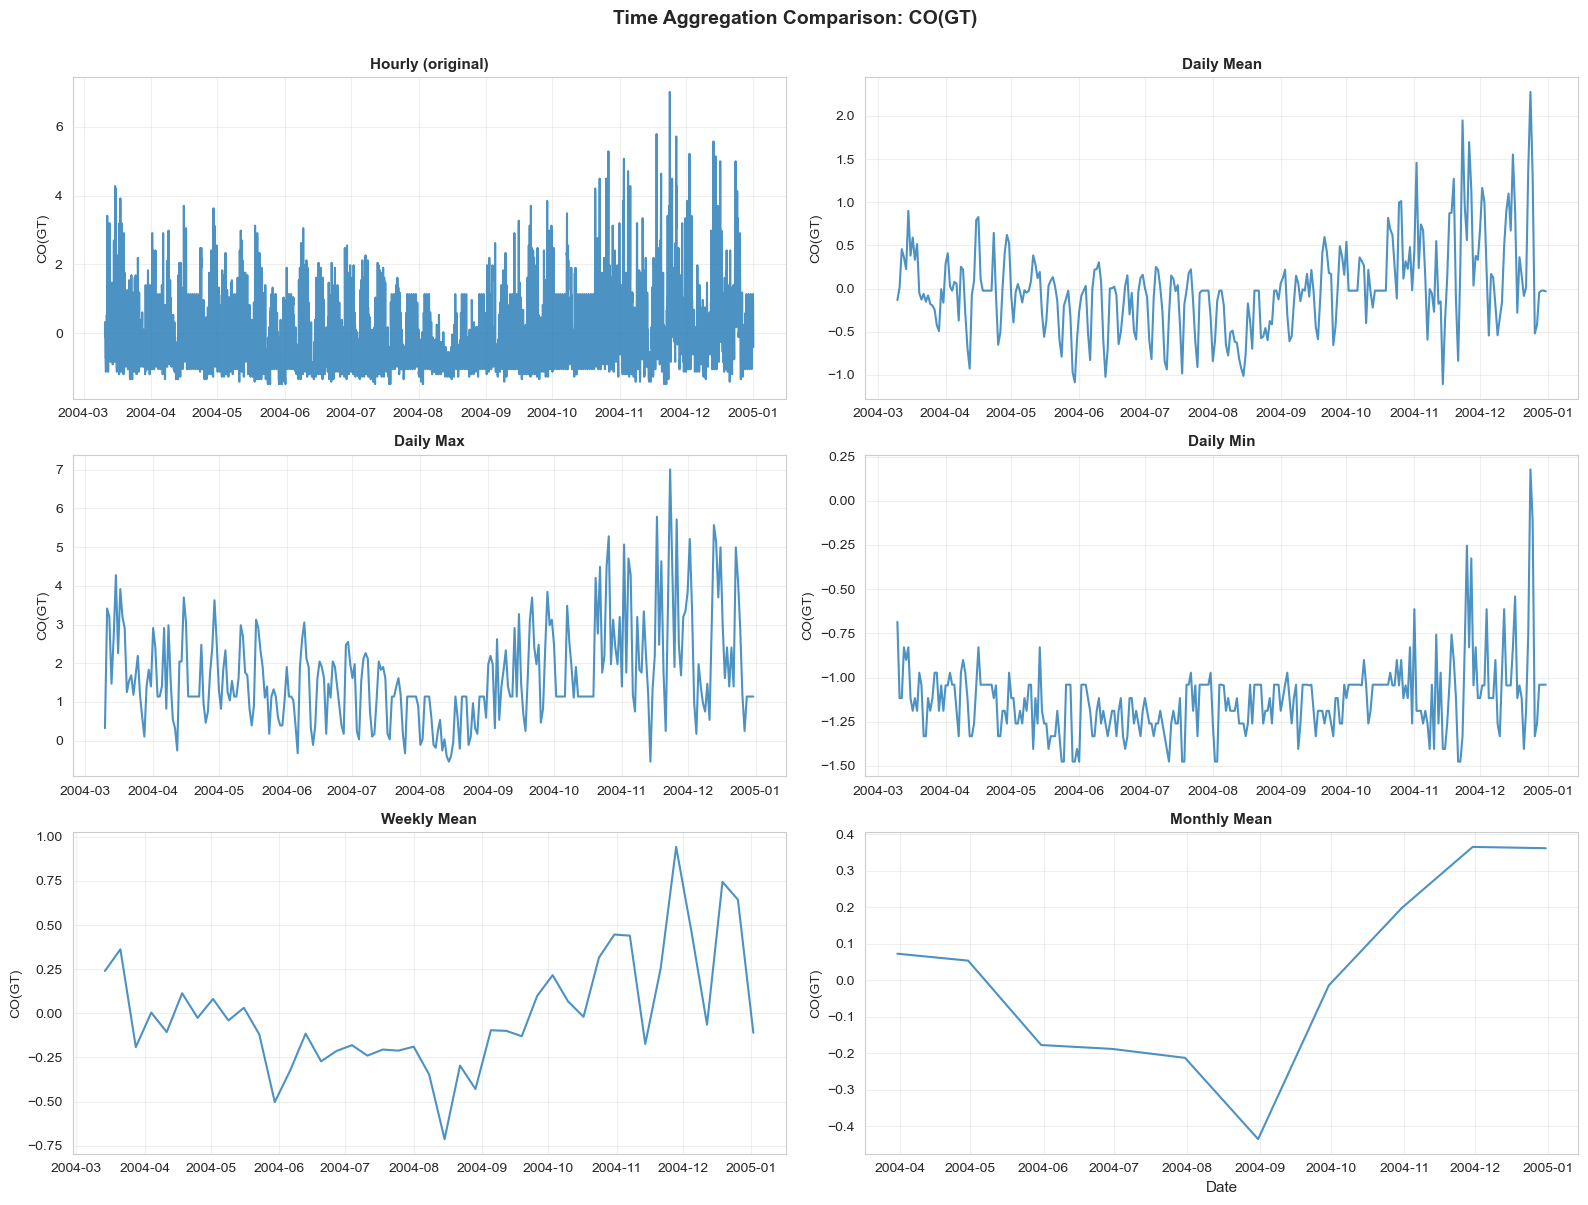

In [13]:
def compare_time_aggregations(df, target_col='CO(GT)'):
    """
    Compare different time aggregation strategies
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe
    target_col : str
        Target column to analyze
    """
    print(f"=== Time Aggregation Comparison for {target_col} ===")
    
    # Different aggregation strategies
    aggregations = {
        'Hourly (original)': df[target_col],
        'Daily Mean': df[target_col].resample('D').mean(),
        'Daily Max': df[target_col].resample('D').max(),
        'Daily Min': df[target_col].resample('D').min(),
        'Weekly Mean': df[target_col].resample('W').mean(),
        'Monthly Mean': df[target_col].resample('M').mean()
    }
    
    # Calculate statistics for each aggregation
    comparison_stats = []
    
    for agg_name, agg_data in aggregations.items():
        stats_dict = {
            'Aggregation': agg_name,
            'Count': len(agg_data.dropna()),
            'Mean': agg_data.mean(),
            'Std': agg_data.std(),
            'Min': agg_data.min(),
            'Max': agg_data.max(),
            'Range': agg_data.max() - agg_data.min()
        }
        comparison_stats.append(stats_dict)
    
    comparison_df = pd.DataFrame(comparison_stats)
    print("\nAggregation Statistics:")
    print(comparison_df.round(4))
    
    # Visualize different aggregations
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, (agg_name, agg_data) in enumerate(aggregations.items()):
        axes[idx].plot(agg_data.index, agg_data.values, linewidth=1.5, alpha=0.8)
        axes[idx].set_title(f'{agg_name}', fontsize=11, fontweight='bold')
        axes[idx].set_ylabel(target_col, fontsize=10)
        axes[idx].grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Date', fontsize=11)
    plt.suptitle(f'Time Aggregation Comparison: {target_col}', 
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
    
    return comparison_df

# Compare aggregations for CO(GT)
aggregation_comparison = compare_time_aggregations(train_data, 'CO(GT)')


## 4.9 Save Engineered Features


In [14]:
import os

print("=== Saving engineered features ===")

# Ensure directory exists
save_dir = '../data/processed'
os.makedirs(save_dir, exist_ok=True)

# Save train and test sets with engineered features
train_final.to_csv(os.path.join(save_dir, 'train_data_engineered.csv'))
test_final.to_csv(os.path.join(save_dir, 'test_data_engineered.csv'))

print(f"✓ Saved train_data_engineered.csv ({train_final.shape})")
print(f"✓ Saved test_data_engineered.csv ({test_final.shape})")

# Save feature list for reference
feature_info = {
    'original_features': continuous_features,
    'lag_features': lag_feature_names,
    'moving_average_features': ma_feature_names,
    'rolling_statistics_features': stat_feature_names,
    'interaction_features': interaction_names,
    'fourier_features': fourier_names,
    'all_engineered_features': all_new_features,
    'total_features': train_final.shape[1],
    'total_samples_train': len(train_final),
    'total_samples_test': len(test_final)
}

import json
with open(os.path.join(save_dir, 'feature_engineering_info.json'), 'w') as f:
    json.dump(feature_info, f, indent=2, default=str)

print(f"✓ Saved feature_engineering_info.json")

print("\n=== Feature Engineering Complete ===")
print(f"Total features created: {len(all_new_features)}")
print(f"Final feature count: {train_final.shape[1]}")
print(f"\nReady for modeling in next step!")


=== Saving engineered features ===
✓ Saved train_data_engineered.csv ((7110, 129))
✓ Saved test_data_engineered.csv ((2247, 129))
✓ Saved feature_engineering_info.json

=== Feature Engineering Complete ===
Total features created: 111
Final feature count: 129

Ready for modeling in next step!
